In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings; warnings.simplefilter('ignore')

# Recomendación: En Jupyter Lab instalar la extensión @aquirdturtle/collapsible_headings para una mejor visualización y orden

__IMPORTANTE__: Simplifiqué los pasos del proyecto 1 a modo de poder tener un notebook más concreto

# <font color=Blue>__Tasador con Machine Learning__</font>

#### __0 - Dataset Original y filtro__

In [5]:
df = pd.read_csv('/Users/juanchi/Documents/Data Science/Curso/Proyecto 1/DS_Proyecto_01_Datos_Properati.csv')
print('El dataset original que vamos a usar tiene', df.shape[1], 'columnas y', df.shape[0], 'filas')

El dataset original que vamos a usar tiene 19 columnas y 146660 filas


Vamos a filtrar por propiedades en CABA que sean PHs, Casas y Departamentos al igual que en el proyecto 1, e incluir los atributos de Latitud, Longitud y Tipo de propiedad. Vamos a sumar el barrio también para inputar luego valores faltantes de Latitud y longitud. No vamos a filtrar nada más por el momento. 

In [6]:
# Filtro tipo de propiedad en Capital Federal

property_filter = ['Departamento', 'PH', 'Casa']
df2 = df[(df.property_type.isin(property_filter)) & (df.l2 == "Capital Federal")]

# Columnas elegidas (sumamos Lat, lon y property_type por lo visto en el P1)
columns = ['rooms', 'bedrooms', 'bathrooms', 'surface_total', 'surface_covered', 
           'price', 'property_type', 'lat', 'lon', 'l3' ] 

#Filtro final
df2 = df2[columns]

print('El dataset filtrado df2 (Deptos, PH, CASA en CABA) tiene', 
      df2.shape[1], 'columnas y', df2.shape[0], 'filas')

df2.isna().sum()

El dataset filtrado df2 (Deptos, PH, CASA en CABA) tiene 10 columnas y 91485 filas


rooms                 0
bedrooms              0
bathrooms          2171
surface_total      8917
surface_covered    9235
price                 0
property_type         0
lat                4534
lon                4548
l3                    0
dtype: int64

#### __1 - Detección y eliminación de Outliers__

##### __EDA Express__

El primer paso antes de pasar a la parte de los modelos es eliminar posibles outliers a modo de luego poder hacer otro tipo de procesamientos de los datos. ¿Por qué primero? Porque con outliers al hacer un input de datos faltantes con la media pueden ser conflictivo y alterar mucho el resultado. 

In [7]:
df2.describe().apply(lambda s: s.apply('{0:.1f}'.format))

,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,lat,lon
count,91485.0,91485.0,89314.0,82568.0,82250.0,91485.0,86951.0,86937.0
mean,3.0,2.0,1.6,112.6,95.0,259500.3,-34.6,-58.4
std,1.3,1.1,0.9,980.7,778.5,322265.4,0.0,0.0
min,1.0,0.0,1.0,10.0,1.0,6000.0,-34.7,-58.5
25%,2.0,1.0,1.0,49.0,44.0,120000.0,-34.6,-58.5
50%,3.0,2.0,1.0,71.0,63.0,175000.0,-34.6,-58.4
75%,4.0,3.0,2.0,111.0,96.0,279000.0,-34.6,-58.4
max,26.0,15.0,14.0,126062.0,126062.0,32434232.0,-34.5,-58.4


Vemos valores atípicos de __precio__ como: Máximos de __USD 32.434.232__ y mínimos de __USD 6.000__. <br>
Vemos valores atípicos de __superficie total__ como: Máximos de __126.062 mt2__ y mínimos de __10 mt2__.<br>
Vemos valores atípicos de __superficie cubierta__ como: Máximos de __126.062 mt2__ y mínimos de __1 mt2__.<br>
Vemos valores atípicos de __habitaciones__ como: Máximos de __15 HAB__ y mínimos de __0 HAB__.<br>
Vemos valores atípicos de __baños__ como: Máximos de __14 Baños__.<br>
Vemos valores atípicos de __ambientes__ como: Máximos de __26 ambientes__.

También notamos valores faltantes pero eso lo vamos a resolver luego.


Vamos a trabajar con métido de __Rango Intercuartílico__ donde cualquier número fuera de este rango (mutiplicado por la constante 1.5 para discernir verdaderos outliers) es un valor atípico. Esto lo haremos sobre __Precio__ y __Superficie Cubierta__ respectivamente a modo de eliminar la mayoría de los outliers y ver cómo responde el dataset a este manejo. En caso de ser necesario trabajaremos sobre los otro features o quitaremos algún valor de forma discrecional.  

##### __Funciones__

In [8]:
# Filtra por rango IQR * 1.5

def iqr (feature, dataframe):
    q25,q75 = np.nanpercentile(dataframe[feature].values, [25,75])
    iqr = q75 - q25
    minimo = round(q25 - 1.5 * iqr)
    maximo = round(q75 + 1.5 * iqr)
    mascara1 = (dataframe[feature] < minimo) | (dataframe[feature] > maximo)
    dataframe = dataframe[~mascara1]
    
    return dataframe

##### __Outliers en columnas__

In [9]:
columns = ['price', 'surface_covered', 'surface_total','rooms', 'bedrooms', 'bathrooms' ]

for col in columns:
    df2 = iqr (col, df2)
    
df2.describe()

,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,lat,lon
count,75211.000000,75211.000000,73304.000000,67133.000000,66866.000000,75211.000000,71898.000000,71887.000000
mean,2.580806,1.660741,1.324880,67.913455,60.534592,177828.476686,-34.599394,-58.437407
std,0.906342,0.786939,0.567047,28.289927,24.503075,87974.669080,0.023526,0.035314
min,1.000000,0.000000,1.000000,10.000000,1.000000,7500.000000,-34.696419,-58.530467
25%,2.000000,1.000000,1.000000,46.000000,42.000000,114000.000000,-34.613799,-58.460145
50%,3.000000,2.000000,1.000000,62.000000,55.000000,155750.000000,-34.600161,-58.434603
75%,3.000000,2.000000,2.000000,84.000000,75.000000,223000.000000,-34.585381,-58.412973
max,4.000000,4.000000,4.000000,154.000000,146.000000,517266.000000,-34.535818,-58.353930


#### __2 -  Corrección de valores mal ingresados e Imputación__

##### <font color=Blue>__Bedrooms__</font>

No tenemos valores NaN pero tenemos valores en 0. Los __bedrooms__ con valor 0 decidimos tratarlos como __NaNs__ e imputar valores. 

In [10]:
print(df2.bedrooms.value_counts())
print(df2[(df2.bedrooms == 0)].rooms.value_counts())

1.0    33686
2.0    26843
3.0    12394
0.0     2200
4.0       88
Name: bedrooms, dtype: int64
1.0    2173
3.0      12
2.0      12
4.0       3
Name: rooms, dtype: int64


In [11]:
condition = (df2.rooms == 1) & (df2.bedrooms == 0)

df2.bedrooms[condition] = df2.bedrooms[condition].replace(0,1)
df2.bedrooms.value_counts()

1.0    35859
2.0    26843
3.0    12394
4.0       88
0.0       27
Name: bedrooms, dtype: int64

In [12]:
df2 = df2[df2.bedrooms > 0]

##### <font color=Blue>__Superficie Cubierta y Superficie total__</font>

###### Imputación valores __surface_total__ <-> __surface_covered__

In [13]:
condition = (df2.surface_covered > df2.surface_total)
df2.surface_covered, df2.surface_total = np.where(condition, [df2.surface_total, df2.surface_covered], 
                                                  [df2.surface_covered, df2.surface_total])

###### Imputación valores null en __surface_total__

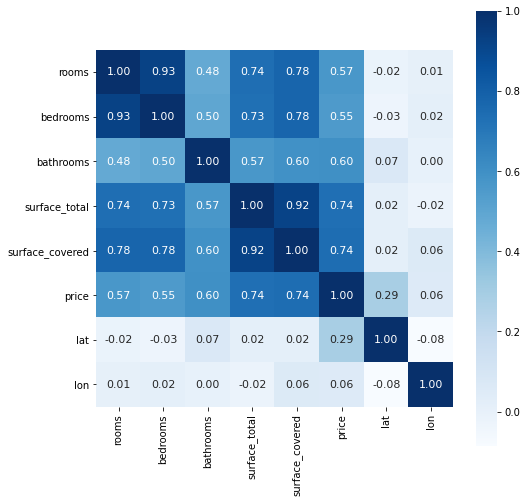

In [14]:
corr = df2.corr()
plt.figure(figsize=(8,8))
sns.heatmap(corr, cbar = True,  square = True, annot=True, fmt= '.2f',annot_kws={'size': 11}, cmap= 'Blues')
plt.show()

La variable más correlacionada con __surface_total__ es __rooms__. Por lo tanto, la vamos a tomar para imputar los valores de mediana dependiendo las instancias. 

In [15]:
values_median_rooms = round(df2.groupby('rooms')['surface_total'].median())

df2.surface_total = df2.surface_total.fillna(df2.rooms.map(values_median_rooms))

###### Imputación valores null en __surface_covered__

Sabemos que la correlación entre __surface_covered__ y __surface_total__ es de 92%. Por eso vamos a imputar los valores en con __surface_total__ menos la media de superficie descubierta de intervalos de tamaño de propiedades.

In [16]:
null = df2.surface_covered.isnull()
df2.surface_covered = np.where(null, df2.surface_total, df2.surface_covered)

###### Imputación valores atípicos en __surface_covered__ (Que no fueron filtrados por IQR)

In [17]:
rare = df2.surface_covered < 13.0
df2.surface_covered = np.where(rare, df2.surface_total, df2.surface_covered)
 
df2 = df2.drop(df2[(df2.surface_covered < 13.0)].index)

##### <font color=Blue>__Latitud y Longitud__</font>

Ya habíamos visto que había 3.409 datos faltantes en __lat__ y 3.423 de __lon__.

In [18]:
valores_medios_lat = df2.groupby('l3')['lat'].mean()
valores_medios_lon = df2.groupby('l3')['lon'].mean()

df2.lat = df2.lat.fillna(df2.l3.map(valores_medios_lat))
df2.lon = df2.lon.fillna(df2.l3.map(valores_medios_lon))

df2 = df2.drop(columns=['l3'])

In [ ]:
df2.describe()

##### <font color=Blue>__Price__</font>

Por ahora seguimos teniendo valores muy bajos de __price__. La hipótesis que vamos a tomar, basado en búsquedas en intenet de propiedades similares, es que muchas veces se publican precios de inmuebles que aún no han sido construido y son oportunidades de negocio. La otra hipótesis es que simplemente, pueden estar cargados y son alquileres. Según nuestra búsqueda en portales web no existen propiedades de menos de USD 25.000.

Ejemplo de descripciones:

1 - AV SAN MARTIN 1244 - VENTA DE POZO ENTREGA FEB...
2 - Crowdfunding - Inverti en Palermo - Desde 4 mts2
3 - OPORTUNIDAD DE INVERSION !

Los vamos a eliminar porque no son parte de lo que buscamos en este proyecto que es predecir precios de inmuebles. 


In [19]:
print(df2[df2.price <= 25000].price.count())
df2 = df2.drop(df2[df2.price <= 25000].index)
print(df2[df2.price <= 25000].price.count())
df2.isna().sum()

19
0


rooms                 0
bedrooms              0
bathrooms          1905
surface_total         0
surface_covered       0
price                 0
property_type         0
lat                   0
lon                   0
dtype: int64

##### __Bathrooms__

In [20]:
values_mean_bathrooms = round(df2.groupby('bedrooms')['bathrooms'].mean())
df2.bathrooms = df2.bathrooms.fillna(df2.bedrooms.map(values_mean_bathrooms))

##### __Dataset Preprocesado__

Para el momento vamos a sacar l3 (que sirvió para imputar valores de Lat y Lon) y resetear el index. 

In [21]:
df2 = df2.reset_index(drop=True)

#### __3 -  Encoders__

Vamos a crear variables numéricas para __property_type__

In [22]:
new_columns = pd.get_dummies(df2.property_type)
df2 = pd.concat([df2, new_columns], axis=1)
df_final = df2.drop(columns=['property_type'])
print('El dataset original tiene', df2.shape[1], 'columnas y', df2.shape[0], 'filas')
df_final.describe()

El dataset original tiene 12 columnas y 75164 filas


,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,lat,lon,Casa,Departamento,PH
count,75164.000000,75164.000000,75164.000000,75164.000000,75164.000000,75164.000000,75164.000000,75164.000000,75164.000000,75164.000000,75164.000000
mean,2.580970,1.690330,1.319382,67.116825,60.508368,177867.680805,-34.599158,-58.436871,0.008076,0.902773,0.089152
std,0.906321,0.742001,0.563054,27.789677,24.204058,87948.950670,0.023394,0.035130,0.089502,0.296269,0.284965
min,1.000000,1.000000,1.000000,13.000000,13.000000,25500.000000,-34.696419,-58.530467,0.000000,0.000000,0.000000
25%,2.000000,1.000000,1.000000,46.000000,42.000000,114000.000000,-34.613672,-58.459478,0.000000,1.000000,0.000000
50%,3.000000,2.000000,1.000000,61.000000,55.000000,155994.000000,-34.599658,-58.434109,0.000000,1.000000,0.000000
75%,3.000000,2.000000,2.000000,83.000000,74.000000,223000.000000,-34.585766,-58.412600,0.000000,1.000000,0.000000
max,4.000000,4.000000,4.000000,154.000000,153.000000,517266.000000,-34.535818,-58.353930,1.000000,1.000000,1.000000


#### __4 - Train_Test_Split y Normalización__

In [34]:
from sklearn.model_selection import train_test_split

columns = ['rooms', 'bedrooms', 'bathrooms', 'surface_total', 'surface_covered', 'lat', 'lon', 'Casa', 'Departamento', 'PH' ]
#columns = ['rooms', 'bedrooms', 'bathrooms', 'surface_total', 'surface_covered']

X = df_final[columns]
y = df_final.price

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [35]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

#### __5 - Modelo KNN__

##### __Función Eval__

In [26]:
def eval_model (X_train, X_test, y_train, y_test, y_train_pred, y_test_pred):
    
    from sklearn.tree import DecisionTreeRegressor
    from sklearn.metrics import mean_squared_error
    #from sklearn.metrics import mean_absolute_error#

    rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
    rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
    #mae_train = np.sqrt(mean_absolute_error(y_train, y_train_pred))
    #mae_test = np.sqrt(mean_absolute_error(y_test, y_test_pred))
    print(f'Raíz del error cuadrático medio en Train: {rmse_train}')
    print(f'Raíz del error cuadrático medio en Test: {rmse_test}')
    #print(f'Error absoluto medio en train: {mae_train}')
    #print(f'Error absoluto medio en test: {mae_test}')
    
    plt.figure(figsize = (15,7))
    
    plt.subplot(1,2,1)
    sns.distplot(y_train - y_train_pred, bins = 15, label = 'train')
    sns.distplot(y_test - y_test_pred, bins = 15, label = 'test')
    plt.xlabel('errores')
    plt.ticklabel_format(style = 'plain')
    plt.legend()
    
    
    ax = plt.subplot(1,2,2)
    ax.scatter(y_test,y_test_pred, s =2)
 
    lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes]
    ]
    
    ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
    plt.xlabel('y (test)')
    plt.ylabel('y_pred (test)')
    
    #plt.tight_layout()
    plt.ticklabel_format(style = 'plain')
    plt.show()

In [36]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV

knn_regressor = KNeighborsRegressor()

param_grid = {'n_neighbors': [0,5,10,15],
               'weights' : ['uniform', 'distance']}

knn_regr_GS = GridSearchCV(knn_regressor, param_grid=param_grid, cv=5)

knn_regr_GS.fit(X_train, y_train)
print("Mejores parametros: "+str(knn_regr_GS.best_params_))
print("Mejor Score: "+str(knn_regr_GS.best_score_)+'\n')

y_test_pred = knn_regr_GS.predict(X_test)
y_train_pred = knn_regr_GS.predict(X_train)

Mejores parametros: {'n_neighbors': 15, 'weights': 'distance'}
Mejor Score: 0.8840220734471987



Raíz del error cuadrático medio en Train: 6523.888668285026
Raíz del error cuadrático medio en Test: 28629.170441154653


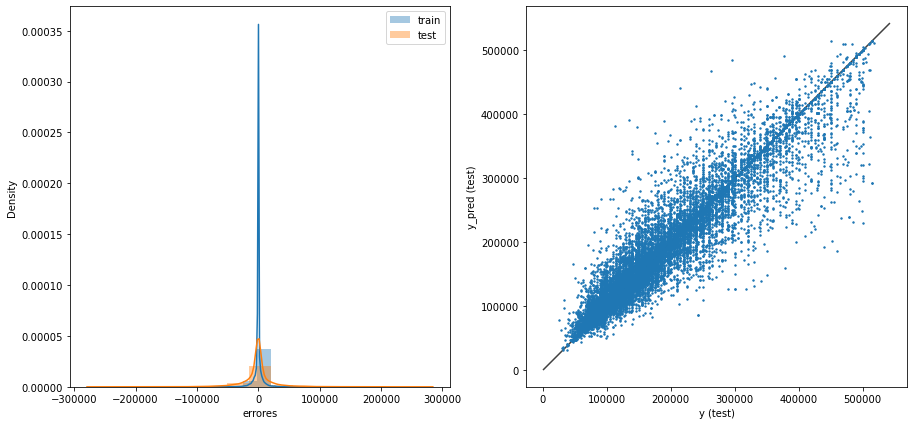

In [37]:
eval_model (X_train, X_test, y_train, y_test, y_train_pred, y_test_pred)

#### __6 - Puesta en producción__

In [ ]:
scaler_final = StandardScaler()
X = scaler_final.fit_transform(X)
knn_regressor = KNeighborsRegressor(n_neighbors=15, weights='distance')
knn_regressor.fit(X, y)
model = {"modelo":knn_regressor,
         "scaler":scaler_final}

In [ ]:
import pickle
with open('./tmp/model.pickle','wb') as file:
    pickle.dump(model, file)